In [1]:
!pip install -U pandas numpy matplotlib seaborn scikit-learn lightgbm shap joblib optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: matplotlib
  

Import Libraries

In [2]:
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# LightGBM model
from lightgbm import LGBMClassifier

# Explainability
import shap

# Save/load
import joblib

# Optional tuning
import optuna


Upload your kaggle.json key

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jerryabraham","key":"0ec07ba36d46db569ca5bfd3fe317b4f"}'}

Set up Kaggle config

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download the dataset

In [9]:
!kaggle competitions download -c home-credit-default-risk

 97% 669M/688M [00:07<00:00, 194MB/s]
100% 688M/688M [00:07<00:00, 91.6MB/s]


Unzip it

In [10]:
!unzip home-credit-default-risk.zip -d home_credit

Archive:  home-credit-default-risk.zip
  inflating: home_credit/HomeCredit_columns_description.csv  
  inflating: home_credit/POS_CASH_balance.csv  
  inflating: home_credit/application_test.csv  
  inflating: home_credit/application_train.csv  
  inflating: home_credit/bureau.csv  
  inflating: home_credit/bureau_balance.csv  
  inflating: home_credit/credit_card_balance.csv  
  inflating: home_credit/installments_payments.csv  
  inflating: home_credit/previous_application.csv  
  inflating: home_credit/sample_submission.csv  


Verify CSVs

In [11]:
!ls /content/home_credit/*.csv


/content/home_credit/application_test.csv
/content/home_credit/application_train.csv
/content/home_credit/bureau_balance.csv
/content/home_credit/bureau.csv
/content/home_credit/credit_card_balance.csv
/content/home_credit/HomeCredit_columns_description.csv
/content/home_credit/installments_payments.csv
/content/home_credit/POS_CASH_balance.csv
/content/home_credit/previous_application.csv
/content/home_credit/sample_submission.csv


Load with Inline Indexing

In [13]:
df = pd.read_csv('/content/home_credit/application_train.csv', index_col='SK_ID_CURR')
print(df.shape)
df.head()


(307511, 121)


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Separate Features into Numerical and Categorical

In [14]:
# Drop target for feature separation
X = df.drop(columns='TARGET')
y = df['TARGET']

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")


Numerical columns: 104
Categorical columns: 16


Define ColumnTransformer Pipeline

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine both in ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


Train-Test Split

In [16]:
from sklearn.model_selection import train_test_split

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(X_train.shape, X_test.shape)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


(246008, 120) (61503, 120)
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


Optuna Tuning with cross_val_score

In [26]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': 42,
        'n_jobs': 1
    }

    model = Pipeline([
        ('preprocess', preprocessor),
        ('lgbm', LGBMClassifier(**params))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

    return auc.mean()

Optuna study

In [24]:
# Mount your Google Drive:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [30]:
# Use SQLite to save progress
study = optuna.create_study(
    study_name="credit_risk_study",
    direction="maximize",
    storage="sqlite:///optuna_study.db",  # Save trials to this file
    load_if_exists=True                   # If file exists, continue from there
)

study.optimize(objective, n_trials=20)

# Optional: See best parameters and best AUC
print("Best score (AUC):", study.best_value)
print("Best parameters:", study.best_params)

[I 2025-07-16 10:39:54,268] Using an existing study with name 'credit_risk_study' instead of creating a new one.
[I 2025-07-16 10:43:23,586] Trial 10 finished with value: 0.7567538652157314 and parameters: {'n_estimators': 404, 'max_depth': 6, 'learning_rate': 0.10499406843667142, 'subsample': 0.7893461775371731, 'colsample_bytree': 0.7576788758208036, 'min_child_samples': 30, 'reg_alpha': 8.245003949715464, 'reg_lambda': 8.406582505472972}. Best is trial 2 with value: 0.7292603364261602.
[I 2025-07-16 10:46:03,213] Trial 11 finished with value: 0.7422164558489989 and parameters: {'n_estimators': 365, 'max_depth': 5, 'learning_rate': 0.32230275030154265, 'subsample': 0.7856512308057026, 'colsample_bytree': 0.7293886275577859, 'min_child_samples': 64, 'reg_alpha': 3.4967223634640665, 'reg_lambda': 8.259804016703159}. Best is trial 2 with value: 0.7292603364261602.
[I 2025-07-16 10:50:31,636] Trial 12 finished with value: 0.7282524356523143 and parameters: {'n_estimators': 676, 'max_dept

Best score (AUC): 0.6944705012851491
Best parameters: {'n_estimators': 798, 'max_depth': 10, 'learning_rate': 0.4971867206524301, 'subsample': 0.6755868747438691, 'colsample_bytree': 0.6029779395909269, 'min_child_samples': 100, 'reg_alpha': 0.11591256765649671, 'reg_lambda': 0.12047220789148994}


In [31]:
print(len(study.trials))

30


In [34]:
# Show the best result
print("\n Best AUC:", study.best_value)
print(" Best Parameters:")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")


 Best AUC: 0.6944705012851491
 Best Parameters:
  n_estimators: 798
  max_depth: 10
  learning_rate: 0.4971867206524301
  subsample: 0.6755868747438691
  colsample_bytree: 0.6029779395909269
  min_child_samples: 100
  reg_alpha: 0.11591256765649671
  reg_lambda: 0.12047220789148994


In [32]:
best_params = study.best_params
best_params

{'n_estimators': 798,
 'max_depth': 10,
 'learning_rate': 0.4971867206524301,
 'subsample': 0.6755868747438691,
 'colsample_bytree': 0.6029779395909269,
 'min_child_samples': 100,
 'reg_alpha': 0.11591256765649671,
 'reg_lambda': 0.12047220789148994}

In [38]:
# Rebuild the pipeline
model = Pipeline([
    ('preprocess', preprocessor),  # This is your ColumnTransformer
    ('lgbm', LGBMClassifier(**best_params))
])


In [39]:
# Fit on training data
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.456916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11234
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 223
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


,steps,"[('preprocess', ...), ('lgbm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [40]:
# AUC Score (Threshold-Independent Metric)
y_pred = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC: 0.7041653882173624


In [41]:
# Print Classification Report and Confusion Matrix (at default threshold 0.5)
from sklearn.metrics import classification_report, confusion_matrix

# Predicted class labels using default threshold of 0.5
y_pred_class = (y_pred >= 0.5).astype(int)

# Classification report
print("Classification Report (Threshold = 0.5):")
print(classification_report(y_test, y_pred_class))

# Confusion matrix
print("Confusion Matrix (Threshold = 0.5):")
print(confusion_matrix(y_test, y_pred_class))


Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     56538
           1       0.32      0.08      0.13      4965

    accuracy                           0.91     61503
   macro avg       0.62      0.53      0.54     61503
weighted avg       0.88      0.91      0.89     61503

Confusion Matrix (Threshold = 0.5):
[[55695   843]
 [ 4575   390]]


In [43]:
# Apply Threshold = 0.25 and Evaluate
from sklearn.metrics import classification_report, confusion_matrix

# Predicted probabilities for class 1 (defaulter)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Apply new threshold
threshold = 0.25
y_pred_thresh = (y_pred_proba >= threshold).astype(int)

# Classification Report
print(f"Classification Report (Threshold = {threshold}):")
print(classification_report(y_test, y_pred_thresh))

# Confusion Matrix
print(f"Confusion Matrix (Threshold = {threshold}):")
print(confusion_matrix(y_test, y_pred_thresh))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Classification Report (Threshold = 0.25):
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     56538
           1       0.24      0.21      0.23      4965

    accuracy                           0.88     61503
   macro avg       0.59      0.58      0.58     61503
weighted avg       0.88      0.88      0.88     61503

Confusion Matrix (Threshold = 0.25):
[[53224  3314]
 [ 3908  1057]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


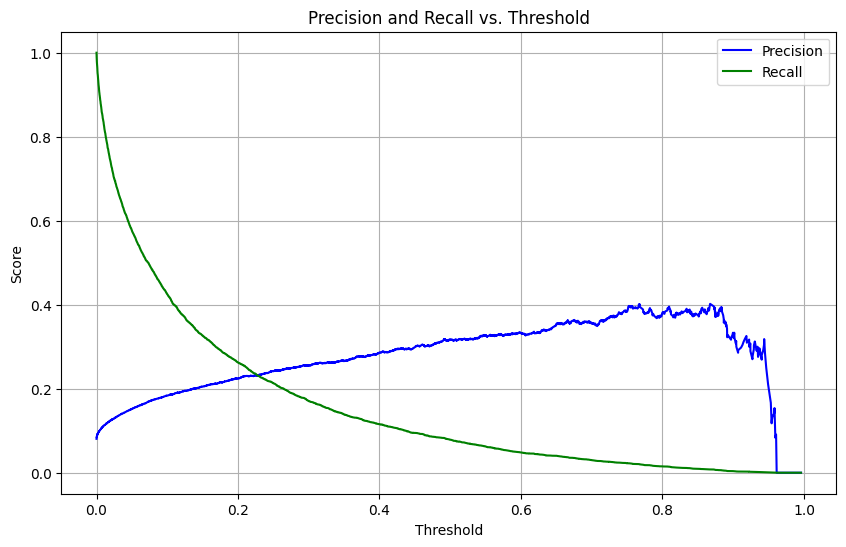

In [44]:
# Precision-Recall vs. Threshold curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Predict probabilities
y_scores = model.predict_proba(X_test)[:, 1]

# Get precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot precision and recall as a function of threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="b")
plt.plot(thresholds, recall[:-1], label="Recall", color="g")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [45]:
# Train and Save Final Model
# Final model pipeline on full data
final_model = Pipeline([
    ('preprocess', preprocessor),
    ('lgbm', LGBMClassifier(**best_params))
])

# Fit the model on full data
final_model.fit(X, y)

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.305534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11242
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


,steps,"[('preprocess', ...), ('lgbm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [53]:
# SHAP to get 20 features
import shap
import pandas as pd

# Sample 5000 rows for SHAP to avoid memory issues
X_sample = X[:5000]

# Use only the LightGBM model for SHAP
lgbm_model = final_model.named_steps["lgbm"]
preprocessor = final_model.named_steps["preprocess"]

# Transform the sample
X_transformed = preprocessor.transform(X_sample)
feature_names = preprocessor.get_feature_names_out()

# Use TreeExplainer safely
explainer = shap.Explainer(lgbm_model, X_transformed, feature_names=feature_names)

# Get SHAP values
shap_values = explainer(X_transformed)

# Get mean absolute SHAP values
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
shap_importance = shap_df.abs().mean().sort_values(ascending=False)
top_20_features = shap_importance.head(20).index.tolist()

print("Top 20 SHAP features:")
print(top_20_features)


100%|===================| 4995/5000 [01:47<00:00]       

Top 20 SHAP features:
['num__EXT_SOURCE_3', 'num__AMT_CREDIT', 'num__AMT_GOODS_PRICE', 'num__EXT_SOURCE_2', 'num__EXT_SOURCE_1', 'num__AMT_ANNUITY', 'num__DAYS_BIRTH', 'num__DAYS_EMPLOYED', 'num__DAYS_ID_PUBLISH', 'num__DAYS_LAST_PHONE_CHANGE', 'num__DAYS_REGISTRATION', 'num__REGION_POPULATION_RELATIVE', 'num__TOTALAREA_MODE', 'num__AMT_INCOME_TOTAL', 'num__HOUR_APPR_PROCESS_START', 'num__NONLIVINGAREA_AVG', 'num__LANDAREA_MEDI', 'num__LIVINGAREA_MODE', 'num__BASEMENTAREA_MODE', 'num__BASEMENTAREA_AVG']


In [54]:
# Data to 20 SHAP Features
# Extract only top 20 columns from transformed training and test sets
X_train_20 = preprocessor.transform(X_train)
X_test_20 = preprocessor.transform(X_test)

# Convert to DataFrame with proper column names
X_train_20 = pd.DataFrame(X_train_20, columns=feature_names)[top_20_features]
X_test_20 = pd.DataFrame(X_test_20, columns=feature_names)[top_20_features]


In [55]:
# Retrain LightGBM on 40 Features
model_20 = LGBMClassifier(**best_params)
model_20.fit(X_train_20, y_train)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4636
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,10
,learning_rate,0.4971867206524301
,n_estimators,798
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,100


In [56]:
# Save the model using joblib
import joblib

joblib.dump(model_20, "credit_risk_model_20.pkl")


['credit_risk_model_20.pkl']

In [57]:
# Save the top 20 feature names for use in Streamlit
import json

with open("top_20_features.json", "w") as f:
    json.dump(top_20_features, f)